## Template to get started with data exploration

The other notebooks show the results of existing analysis. Most of the resulting code has been moved from the notebooks to the associated python modules, in order to showcase the results. But that makes it harder to experiment with the data and come up with new analyses. This is particularly true because the current data structures that store the data are a little complicated. Maybe after we switch to xarrays in the future, we will no longer need this!

But for now, users can use this exploration template and plug in their code/analyses here. And finally, they can put the code into a module for re-use elsewhere

## Set up the dependencies

In [1]:
# for reading and validating data
import emeval.input.spec_details as eisd
import emeval.input.phone_view as eipv
import emeval.input.eval_view as eiev

In [2]:
# Visualization helpers
import emeval.viz.phone_view as ezpv
import emeval.viz.eval_view as ezev

In [3]:
# For plots
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# For maps
import folium
import branca.element as bre

In [5]:
# For easier debugging while working on modules
import importlib

## The spec

The spec defines what experiments were done, and over which time ranges. Once the experiment is complete, most of the structure is read back from the data, but we use the spec to validate that it all worked correctly. The spec also contains the ground truth for the legs. Here, we read the spec for the trip to UC Berkeley.

In [6]:
DATASTORE_URL = "http://cardshark.cs.berkeley.edu"
AUTHOR_EMAIL = "shankari@eecs.berkeley.edu"
sd = eisd.SpecDetails(DATASTORE_URL, AUTHOR_EMAIL, "train_bus_ebike_mtv_ucb")

About to retrieve messages using {'user': 'shankari@eecs.berkeley.edu', 'key_list': ['config/evaluation_spec'], 'start_time': 0, 'end_time': 1578356929}
response = <Response [200]>
Found 15 entries
After iterating over 15 entries, entry found
Found spec = Multimodal multi-train, multi-bus, ebike trip to UC Berkeley
Evaluation ran from 2019-07-16T00:00:00-07:00 -> 2019-08-30T00:00:00-07:00


## The views

There are two main views for the data - the phone view and the evaluation view. 

### Phone view

In the phone view, the phone is primary, and then there is a tree that you can traverse to get the data that you want. Traversing that tree typically involves nested for loops; here's an example of loading the phone view and traversing it. You can replace the print statements with real code. When you are ready to check this in, please move the function to one of the python modules so that we can invoke it more generally

In [7]:
pv = eipv.PhoneView(sd)

-------------------- About to read transitions from server --------------------
Reading data for android phones
Loading transitions for phone ucb-sdb-android-1
About to retrieve messages using {'user': 'ucb-sdb-android-1', 'key_list': ['manual/evaluation_transition'], 'start_time': 1563260400, 'end_time': 1567148400}
response = <Response [200]>
Found 72 entries
Loading transitions for phone ucb-sdb-android-2
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['manual/evaluation_transition'], 'start_time': 1563260400, 'end_time': 1567148400}
response = <Response [200]>
Found 60 entries
Loading transitions for phone ucb-sdb-android-3
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['manual/evaluation_transition'], 'start_time': 1563260400, 'end_time': 1567148400}
response = <Response [200]>
Found 60 entries
Loading transitions for phone ucb-sdb-android-4
About to retrieve messages using {'user': 'ucb-sdb-android-4', 'key_list': ['manual/

After copying found 2/2 phones with ground truth for experiment of size 3
Before copying found 1/2 phones with ground truth for experiment of size 3
Uncopied ground truth of length 3 on found on phone ios
Copying 3 ranges to android, fixed:ACCURACY_CONTROL_2
After copying found 2/2 phones with ground truth for experiment of size 3
dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
Found accuracy control, skipping copy
android: Copying ucb-sdb-android-2 accuracy trips to 3, before = 0
('mtv_to_berkeley_sf_bart_0', 9295.5172290802, <Arrow [2019-07-24T07:51:42.185629-07:00]>, <Arrow [2019-07-24T10:26:37.702858-07:00]>)
('walk_urban_university_0', 798.0864510536194, <Arrow [2019-07-24T14:12:16.706653-07:00]>, <Arrow [2019-07-24T14:25:34.793104-07:00]>)
('berkeley_to_mtv_SF_express_bus_0', 12131.998807907104, <Arrow [2019-07-24T16:37:07.662981-07:00]>, <Arrow [2019-07-24T19:59:19.661789-07:00]>)
android: Copying ucb-sdb-android-2 accuracy trips t

response = <Response [200]>
Found 20 entries
About to retrieve messages using {'user': 'ucb-sdb-android-1', 'key_list': ['background/battery'], 'start_time': 1564153794.979, 'end_time': 1564198662.867}
response = <Response [200]>
Found 22 entries
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/battery'], 'start_time': 1563979684.205, 'end_time': 1564026016.571}
response = <Response [200]>
Found 37 entries
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/battery'], 'start_time': 1564067129.194, 'end_time': 1564111993.08}
response = <Response [200]>
Found 30 entries
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/battery'], 'start_time': 1564153809.884, 'end_time': 1564198662.867}
response = <Response [200]>
Found 32 entries
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['background/battery'], 'start_time': 1563979700.651, 'end_time': 1564026

response = <Response [200]>
Found 14149 entries
Retrieved 14149 entries with timestamps [1563979683.523, 1563979683.523, 1563979686.541, 1563979691, 1563979692, 1563979693, 1563979694, 1563979695, 1563979696, 1563979697]...
About to retrieve data for ucb-sdb-android-2 from 1564021868.503 -> 1564026016.571
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/location'], 'start_time': 1564021868.503, 'end_time': 1564026016.571}
response = <Response [200]>
Found 1 entries
Retrieved 1 entries with timestamps [1564021794]...
About to retrieve data for ucb-sdb-android-2 from 1563979684.205 -> 1564026016.571
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['background/filtered_location'], 'start_time': 1563979684.205, 'end_time': 1564026016.571}
response = <Response [200]>
Found 13485 entries
Retrieved 13485 entries with timestamps [1563979683.523, 1563979686.541, 1563979691, 1563979692, 1563979693, 1563979694, 1563979695, 15639796

response = <Response [200]>
Found 721 entries
Retrieved 721 entries with timestamps [1564154023.987, 1564154050, 1564154055, 1564154088.096, 1564154119.23, 1564154150, 1564154180, 1564154211, 1564154241, 1564154271]...
About to retrieve data for ucb-sdb-android-3 from 1564196589.259 -> 1564198700.606
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['background/filtered_location'], 'start_time': 1564196589.259, 'end_time': 1564198700.606}
response = <Response [200]>
Found 1 entries
Retrieved 1 entries with timestamps [1564196587.808]...
About to retrieve data for ucb-sdb-android-4 from 1563979710.362 -> 1564026103.196
About to retrieve messages using {'user': 'ucb-sdb-android-4', 'key_list': ['background/location'], 'start_time': 1563979710.362, 'end_time': 1564026103.196}
response = <Response [200]>
Found 13 entries
Retrieved 13 entries with timestamps [1563981125.944, 1563986021, 1563990284.547, 1563990646.076, 1563991253.962, 1563992440.944, 1564002587, 156

response = <Response [200]>
Found 10525 entries
Retrieved 10525 entries with timestamps [1563980044.385489, 1563980046.1162372, 1563980047.1293101, 1563980047.999834, 1563980048.9998174, 1563980049.9998074, 1563980050.9997978, 1563980051.9997861, 1563980053.999772, 1563980054.9997654]...
About to retrieve data for ucb-sdb-ios-2 from 1564023575.4856539 -> 1564026158.946105
About to retrieve messages using {'user': 'ucb-sdb-ios-2', 'key_list': ['background/filtered_location'], 'start_time': 1564023575.4856539, 'end_time': 1564026158.946105}
response = <Response [200]>
Found 1 entries
Retrieved 1 entries with timestamps [1564023574.9863236]...
About to retrieve data for ucb-sdb-ios-2 from 1564067067.1988769 -> 1564111964.549928
About to retrieve messages using {'user': 'ucb-sdb-ios-2', 'key_list': ['background/location'], 'start_time': 1564067067.1988769, 'end_time': 1564111964.549928}
response = <Response [200]>
Found 9516 entries
Retrieved 9516 entries with timestamps [1564030805.636556

response = <Response [200]>
Found 1858 entries
Retrieved 1858 entries with timestamps [1564154572.964088, 1564154849.341601, 1564155206.677164, 1564155222.038831, 1564155229.005299, 1564155244.811119, 1564155251.220082, 1564155273.199754, 1564155287.32566, 1564155303.520263]...
About to retrieve data for ucb-sdb-ios-3 from 1564198595.322917 -> 1564198601.973415
About to retrieve messages using {'user': 'ucb-sdb-ios-3', 'key_list': ['background/filtered_location'], 'start_time': 1564198595.322917, 'end_time': 1564198601.973415}
response = <Response [200]>
Found 1 entries
Retrieved 1 entries with timestamps [1564198595.1684551]...
About to retrieve data for ucb-sdb-ios-4 from 1563979641.0170379 -> 1564026207.1437001
About to retrieve messages using {'user': 'ucb-sdb-ios-4', 'key_list': ['background/location'], 'start_time': 1563979641.0170379, 'end_time': 1564026207.1437001}
response = <Response [200]>
Found 0 entries
Retrieved 0 entries with timestamps []...
About to retrieve data for u

response = <Response [200]>
Found 698 entries
Retrieved 698 entries with timestamps [1563980015.461, 1563980047.359, 1563980079.258, 1563980111.398, 1563980143.416, 1563980175.238, 1563980207.518, 1563980239.378, 1563980270.25, 1563980301.293]...
About to retrieve data for ucb-sdb-android-3 from 1564023754.787 -> 1564026069.823
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['background/motion_activity'], 'start_time': 1564023754.787, 'end_time': 1564026069.823}
response = <Response [200]>
Found 1 entries
Retrieved 1 entries with timestamps [1564023754.787]...
motion activity has not been processed, copying write_ts -> ts
About to retrieve data for ucb-sdb-android-3 from 1564067142.572 -> 1564112040.915
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['background/motion_activity'], 'start_time': 1564067142.572, 'end_time': 1564112040.915}
response = <Response [200]>
Found 687 entries
Retrieved 687 entries with timestamps [156406735

response = <Response [200]>
Found 876 entries
Retrieved 876 entries with timestamps [1564067075.7060583, 1564067118.189924, 1564067133.1899233, 1564067203.1899235, 1564068160.3211665, 1564068170.611237, 1564068199.9675472, 1564068230.266452, 1564068231.1928625, 1564068238.6889453]...
About to retrieve data for ucb-sdb-ios-2 from 1564111932.0364618 -> 1564111964.549928
About to retrieve messages using {'user': 'ucb-sdb-ios-2', 'key_list': ['background/motion_activity'], 'start_time': 1564111932.0364618, 'end_time': 1564111964.549928}
response = <Response [200]>
Found 1 entries
Retrieved 1 entries with timestamps [1564111932.0364618]...
About to retrieve data for ucb-sdb-ios-2 from 1564153741.210318 -> 1564198491.704329
About to retrieve messages using {'user': 'ucb-sdb-ios-2', 'key_list': ['background/motion_activity'], 'start_time': 1564153741.210318, 'end_time': 1564198491.704329}
response = <Response [200]>
Found 889 entries
Retrieved 889 entries with timestamps [1564153742.456079, 1

response = <Response [200]>
Found 17 entries
transition has not been processed, creating ts -> fmt_time
About to retrieve messages using {'user': 'ucb-sdb-android-2', 'key_list': ['statemachine/transition'], 'start_time': 1564153809.884, 'end_time': 1564198662.867}
response = <Response [200]>
Found 19 entries
transition has not been processed, creating ts -> fmt_time
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['statemachine/transition'], 'start_time': 1563979700.651, 'end_time': 1564026069.823}
response = <Response [200]>
Found 19 entries
transition has not been processed, creating ts -> fmt_time
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['statemachine/transition'], 'start_time': 1564067142.572, 'end_time': 1564112040.915}
response = <Response [200]>
Found 19 entries
transition has not been processed, creating ts -> fmt_time
About to retrieve messages using {'user': 'ucb-sdb-android-3', 'key_list': ['statemachine/transiti

In [8]:
for phone_os, phone_map in pv.map().items():
    print(15 * "=*")
    print(phone_os, phone_map.keys())
    for phone_label, phone_detail_map in phone_map.items():
        print(4 * ' ', 15 * "-*")
        print(4 * ' ', phone_label, phone_detail_map.keys())
        # this spec does not have any calibration ranges, but evaluation ranges are actually cooler
        for r in phone_detail_map["evaluation_ranges"]:
            print(8 * ' ', 30 * "=")
            print(8 * ' ',r.keys())
            print(8 * ' ',r["trip_id"], r["eval_common_trip_id"], r["eval_role"], len(r["evaluation_trip_ranges"]))
            for tr in r["evaluation_trip_ranges"]:
                print(12 * ' ', 30 * "-")
                print(12 * ' ',tr["trip_id"], tr.keys())
                for sr in tr["evaluation_section_ranges"]:
                    print(16 * ' ', 30 * "~")
                    print(16 * ' ',sr["trip_id"], sr.keys())

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 dict_keys(['role', 'transitions', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'battery_entries', 'battery_df', 'location_entries', 'filtered_location_entries', 'location_df', 'filtered_location_df', 'motion_activity_entries', 'motion_activity_df', 'transition_entries', 'transition_df'])
         fixed:ACCURACY_CONTROL_0 HAHFDC v/s HAMFDC accuracy_control_0 3
             ------------------------------
             mtv_to_berkeley_sf_bart_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'batte

         HAHFDC v/s MAHFDC:HAHFDC_2 HAHFDC v/s MAHFDC HAHFDC_2 3
             ------------------------------
             mtv_to_berkeley_sf_bart_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 walk_to_caltrain_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 wait_for_commuter_rail_aboveground_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 commuter_rail_aboveground_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', '

                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 commuter_rail_aboveground_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 tt_commuter_rail_aboveground_subway_underground_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 wait_for_subway_underground_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 subway_underground_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])

### Eval view

In the eval view, the experiment is primary, and then there is a similar tree that you can traverse to get the data that you want. Traversing that tree typically involves nested for loops; here's an example of manipulating the eval view and traversing it. You can replace the print statements with real code. When you are ready to check this in, please move the function to one of the python modules so that we can invoke it more generally

In [9]:
ev = eiev.EvaluationView()
ev.from_view_eval_trips(pv, "", "")

Processing data for android phones
['accuracy_control_0', 'HAHFDC_0', 'HAMFDC_0', 'power_control_0']
Common trip id = mtv_to_berkeley_sf_bart_0
Common trip id = walk_urban_university_0
Common trip id = berkeley_to_mtv_SF_express_bus_0
['accuracy_control_1', 'HAHFDC_1', 'HAMFDC_1', 'power_control_1']
Common trip id = mtv_to_berkeley_sf_bart_0
Common trip id = walk_urban_university_0
Common trip id = berkeley_to_mtv_SF_express_bus_0
['accuracy_control_2', 'HAHFDC_2', 'HAMFDC_2', 'power_control_2']
Common trip id = mtv_to_berkeley_sf_bart_0
Common trip id = walk_urban_university_0
Common trip id = berkeley_to_mtv_SF_express_bus_0
Processing data for ios phones
['accuracy_control_0', 'HAHFDC_0', 'MAHFDC_0', 'power_control_0']
Common trip id = mtv_to_berkeley_sf_bart_0
Common trip id = walk_urban_university_0
Common trip id = berkeley_to_mtv_SF_express_bus_0
['accuracy_control_1', 'HAHFDC_1', 'MAHFDC_1', 'power_control_1']
Common trip id = mtv_to_berkeley_sf_bart_0
Common trip id = walk_urb

In [10]:
for phone_os, eval_map in ev.map("evaluation").items():
    print(15 * "=*")
    print(phone_os, eval_map.keys())
    for (curr_calibrate, curr_calibrate_trip_map) in eval_map.items():
        print(4 * ' ', 15 * "-*")
        print(4 * ' ', curr_calibrate, curr_calibrate_trip_map.keys())
        for trip_id, trip_map in curr_calibrate_trip_map.items():
            print(8 * ' ', 30 * "=")
            print(8 * ' ', trip_id, trip_map.keys())
            for run_label, tr in trip_map.items():
                print(12 * ' ', 30 * "=")
                print(12 * ' ', run_label, tr.keys())
                for sr in tr["evaluation_section_ranges"]:
                    print(16 * ' ', 30 * "~")
                    print(16 * ' ',sr["trip_id"], sr.keys())

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['HAHFDC v/s HAMFDC'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     HAHFDC v/s HAMFDC dict_keys(['mtv_to_berkeley_sf_bart_0', 'walk_urban_university_0', 'berkeley_to_mtv_SF_express_bus_0'])
         mtv_to_berkeley_sf_bart_0 dict_keys(['accuracy_control_0', 'HAHFDC_0', 'HAMFDC_0', 'power_control_0', 'accuracy_control_1', 'HAHFDC_1', 'HAMFDC_1', 'power_control_1', 'accuracy_control_2', 'HAHFDC_2', 'HAMFDC_2', 'power_control_2'])
             accuracy_control_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 walk_to_caltrain_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 wait_fo

                 wait_for_light_rail_below_above_ground_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 light_rail_below_above_ground_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 tt_light_rail_below_above_ground_commuter_rail_with_tunnels_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 wait_for_commuter_rail_with_tunnels_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
   

                 walk_urban_university_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
         berkeley_to_mtv_SF_express_bus_0 dict_keys(['accuracy_control_0', 'HAHFDC_0', 'MAHFDC_0', 'power_control_0', 'accuracy_control_1', 'HAHFDC_1', 'MAHFDC_1', 'power_control_1', 'accuracy_control_2', 'HAHFDC_2', 'MAHFDC_2', 'power_control_2'])
             accuracy_control_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 walk to the bikeshare location_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                 ebike_bikeshare_urban_long_

### Ground truth

The ground truth is stored in the spec, and we can retrieve it from there. Once we have retrieved the trip, there are many possible analyses using them. Please see `get_concat_trajectories` for an example.

### For trips

Using the phone view as an example

In [11]:
for phone_os, phone_map in pv.map().items():
    print(15 * "=*")
    print(phone_os, phone_map.keys())
    for phone_label, phone_detail_map in phone_map.items():
        print(4 * ' ', 15 * "-*")
        print(4 * ' ', phone_label, phone_detail_map["role"], phone_detail_map.keys())
        # this spec does not have any calibration ranges, but evaluation ranges are actually cooler
        for r in phone_detail_map["evaluation_ranges"]:
            print(8 * ' ', 30 * "=")
            print(8 * ' ',r.keys())
            print(8 * ' ',r["trip_id"], r["eval_common_trip_id"], r["eval_role"], len(r["evaluation_trip_ranges"]))
            for tr in r["evaluation_trip_ranges"]:
                print(12 * ' ', 30 * "-")
                print(12 * ' ',tr["trip_id"], tr.keys())
                # I am not printing the actual trajectories since that would be too long, only displaying modes
                gt_trip = sd.get_ground_truth_for_trip(tr["trip_id_base"])
                print(12 * ' ', eisd.SpecDetails.get_concat_trajectories(gt_trip)["properties"])

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'transitions', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'battery_entries', 'battery_df', 'location_entries', 'filtered_location_entries', 'location_df', 'filtered_location_df', 'motion_activity_entries', 'motion_activity_df', 'transition_entries', 'transition_df'])
         fixed:ACCURACY_CONTROL_0 HAHFDC v/s HAMFDC accuracy_control_0 3
             ------------------------------
             mtv_to_berkeley_sf_bart_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_sectio

             walk_urban_university_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
walk_urban_university 1 ['walk_urban_university']
             {'modes': ['WALKING']}
             ------------------------------
             berkeley_to_mtv_SF_express_bus_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
berkeley_to_mtv_SF_express_bus 1 ['berkeley_to_mtv_SF_express_bus']
             {'modes': ['WALKING', 'BICYCLING', 'BUS', 'WALKING', 'LIGHT_RAIL', 'TRAIN', 'WALKING']}
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'battery_entries', 'battery_df', 'location_entries', 'filtered_l

             {'modes': ['WALKING', 'TRAIN', 'SUBWAY', 'WALKING', 'BUS']}
             ------------------------------
             walk_urban_university_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
walk_urban_university 1 ['walk_urban_university']
             {'modes': ['WALKING']}
             ------------------------------
             berkeley_to_mtv_SF_express_bus_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
berkeley_to_mtv_SF_express_bus 1 ['berkeley_to_mtv_SF_express_bus']
             {'modes': ['WALKING', 'BICYCLING', 'BUS', 'WALKING', 'LIGHT_RAIL', 'TRAIN', 'WALKING']}
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_ro

## For sections

Using the eval view as an example

In [12]:
for phone_os, eval_map in ev.map("evaluation").items():
    print(15 * "=*")
    print(phone_os, eval_map.keys())
    for (curr_calibrate, curr_calibrate_trip_map) in phone_map.items():
        print(4 * ' ', 15 * "-*")
        print(4 * ' ', curr_calibrate, curr_calibrate_trip_map.keys())
        for r in curr_calibrate_trip_map["evaluation_ranges"]:
            print(8 * ' ', 30 * "=")
            print(8 * ' ',r.keys())
            print(8 * ' ',r["trip_id"], r["eval_common_trip_id"], r["eval_role"], len(r["evaluation_trip_ranges"]))
            for tr in r["evaluation_trip_ranges"]:
                print(12 * ' ', 30 * "-")
                print(12 * ' ',tr["trip_id"], tr.keys())
                for sr in tr["evaluation_section_ranges"]:
                    print(16 * ' ', 30 * "-")
                    gt_leg = sd.get_ground_truth_for_leg(tr["trip_id_base"], sr["trip_id_base"])
                    print(16 * ' ', sr["trip_id"], gt_leg["mode"], sr.keys())

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['HAHFDC v/s HAMFDC'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-ios-1 dict_keys(['role', 'transitions', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'battery_entries', 'battery_df', 'location_entries', 'filtered_location_entries', 'location_df', 'filtered_location_df', 'motion_activity_entries', 'motion_activity_df', 'transition_entries', 'transition_df'])
         fixed:ACCURACY_CONTROL_0 HAHFDC v/s MAHFDC accuracy_control_0 3
             ------------------------------
             mtv_to_berkeley_sf_bart_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
    

                 walk_to_bus_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 wait_for_city_bus_short_0 STOPPED dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 city_bus_short_0 BUS dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 walk_end_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
             ------------------------------
             walk_urban_university_0

                 tt_commuter_rail_aboveground_subway_underground_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 wait_for_subway_underground_0 STOPPED dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 subway_underground_0 SUBWAY dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 walk_to_bus_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 -------------

                 tt_light_rail_below_above_ground_commuter_rail_with_tunnels_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 wait_for_commuter_rail_with_tunnels_0 STOPPED dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 commuter_rail_with_tunnels_0 TRAIN dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 inner_suburb_downtown_walk_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'trans

             ------------------------------
             mtv_to_berkeley_sf_bart_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 walk_to_caltrain_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 wait_for_commuter_rail_aboveground_0 STOPPED dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 commuter_rail_aboveground_0 TRAIN dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activit

                 ------------------------------
                 walk_end_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
             ------------------------------
             walk_urban_university_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 walk_urban_university_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
             ------------------------------
             berkeley_to_mtv_SF_express_bus_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_d

                 walk_end_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
             ------------------------------
             walk_urban_university_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ------------------------------
                 walk_urban_university_0 WALKING dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
             ------------------------------
             berkeley_to_mtv_SF_express_bus_0 dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'evaluation_section_ranges', 'battery_df', 'location_df', 'motion_activity_df', 'transition_df'])
                 ---------

### Work with a single trip

You can also work with the details of a single trip - here, we look at the battery drain across phones for the third repetition. Code inspired by `plot_all_power_drain`, located in `emeval.viz.phone_view`

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'transitions', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         fixed:POWER_CONTROL_2 HAHFDC v/s MAHFDC power_control_2 3
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-2 evaluation_0 dict_keys(['role', 'transitions', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         fixed:POWER_CONTROL_2 HAHFDC v/s MAHFDC power_control_2 3
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-3 evaluation_1 dict_keys(['role', 'transitions', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         fixed:POWER_CONTROL_2 HAHFDC v/s MAHFDC power_control_2 3
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-an

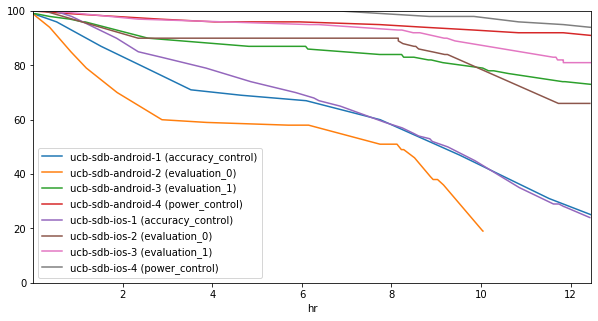

In [13]:
ifig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
for phone_os, phone_map in pv.map().items():
    print(15 * "=*")
    print(phone_os, phone_map.keys())
    for phone_label, phone_detail_map in phone_map.items():
        print(4 * ' ', 15 * "-*")
        print(4 * ' ', phone_label, phone_detail_map["role"], phone_detail_map.keys())
        curr_range = phone_detail_map["evaluation_ranges"][2]
        print(8 * ' ',r["trip_id"], r["eval_common_trip_id"], r["eval_role"], len(r["evaluation_trip_ranges"]))
        battery_df = curr_range["battery_df"]
        battery_df.plot(x="hr", y="battery_level_pct", ax=ax,
                        label="%s (%s)" % (phone_label, phone_detail_map["role"]), ylim=(0,100))

### Work with a single leg

You can also work with the details of a single leg. This is not likely to be useful for power estimates because there are so few points, but it is going to be easier to work with trajectory estimates

In [14]:
third_repetition = pv.map()["ios"]["ucb-sdb-ios-1"]["evaluation_ranges"][2]; third_repetition["trip_id"]

'fixed:ACCURACY_CONTROL_2'

In [15]:
to_ucb_trip = third_repetition["evaluation_trip_ranges"][0]; print(to_ucb_trip["trip_id"])
bart_leg = to_ucb_trip["evaluation_section_ranges"][5]; bart_leg["trip_id"]

mtv_to_berkeley_sf_bart_0


'subway_underground_0'

In [16]:
gt_leg = sd.get_ground_truth_for_leg(to_ucb_trip["trip_id_base"], bart_leg["trip_id_base"]); gt_leg["id"]

'subway_underground'

#### Display the leg

Note the layer control on the map that allows you to toggle the lines separately

In [17]:
curr_map = folium.Map()
gt_leg_gj = sd.get_geojson_for_leg(gt_leg)
sensed_section_gj = ezpv.get_geojson_for_leg(bart_leg)
gt_leg_gj_feature = folium.GeoJson(gt_leg_gj, name="ground_truth")
sensed_leg_gj_feature = folium.GeoJson(sensed_section_gj, name="sensed_values")
curr_map.add_child(gt_leg_gj_feature)
curr_map.add_child(sensed_leg_gj_feature)
curr_map.fit_bounds(sensed_leg_gj_feature.get_bounds())
folium.LayerControl().add_to(curr_map)
curr_map

AttributeError: module 'emeval.viz.phone_view' has no attribute 'get_geojson_for_leg'

#### Display the leg with points

In this case, the points are in a separate layer so they can be toggled indepdendently of the underlying lines

In [ ]:
curr_map = folium.Map()
gt_leg_gj = sd.get_geojson_for_leg(gt_leg)
sensed_section_gj = ezpv.get_geojson_for_leg(bart_leg)
gt_leg_gj_feature = folium.GeoJson(gt_leg_gj, name="ground_truth")
gt_leg_gj_points = ezpv.get_point_markers(gt_leg_gj[2], name="ground_truth_points", color="green")
sensed_leg_gj_feature = folium.GeoJson(sensed_section_gj, name="sensed_values")
sensed_leg_gj_points = ezpv.get_point_markers(sensed_section_gj, name="sensed_points", color="red")
curr_map.add_child(gt_leg_gj_feature)
curr_map.add_child(gt_leg_gj_points)
curr_map.add_child(sensed_leg_gj_feature)
curr_map.add_child(sensed_leg_gj_points)
curr_map.fit_bounds(sensed_leg_gj_feature.get_bounds())
folium.LayerControl().add_to(curr_map)
curr_map